In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

from tied_utils_decay2 import tied_abs_units_decay, prob_of_hitting_down_in_norm_units, decay_sigmoid
from scipy.integrate import trapezoid
import pandas as pd

# params

In [2]:
# Stim params
# ILD_arr = [-6, -3, 0, 3, 6]
# ABL_arr = [20, 40, 60]

# ILD_arr = [1, -1, 2, -2, 4, -4, 8, -8, 16, -16]
ILD_arr = [2]
ABL_arr = [40]

t_non_decision = 0
rate_lambda = 0.2
T_0 = 1 * 1e-3
theta_E = 20
dt = 1e-4

# gamma, mu_d, sigma_d, alpha
gamma = 0.035
mu_d = 0.1
sigma_d = 0.05
alpha = 0.3

decay_params = {'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha}
# sim params
N_sim = int(50e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results_og = Parallel(n_jobs=-1)(delayed(tied_abs_units_decay)(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt, decay_params) for _ in range(N_sim))

In [4]:
# remove elements if 'choice' is none
sim_results = [x for x in sim_results_og if x['choice'] is not None]
print(f"Number of valid simulations: {len(sim_results)}")

Number of valid simulations: 50000


In [5]:
nan_sim_results = [x for x in sim_results_og if x['choice'] is None]
print(f"Number of NaN simulations: {len(nan_sim_results)}")

Number of NaN simulations: 0


(0.0, 2.0)

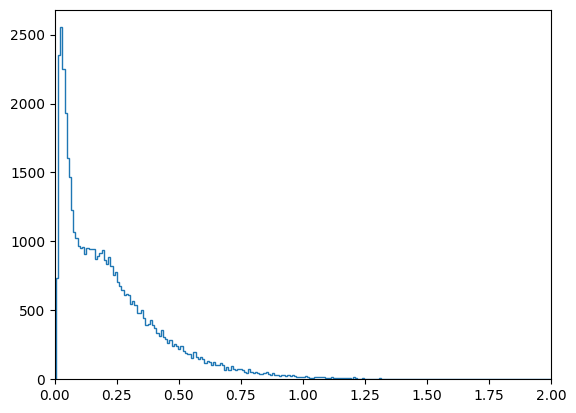

In [7]:
plt.hist([res['rt'] for res in sim_results], bins=250, histtype='step');
plt.xlim(0,2)

# Likelihood check

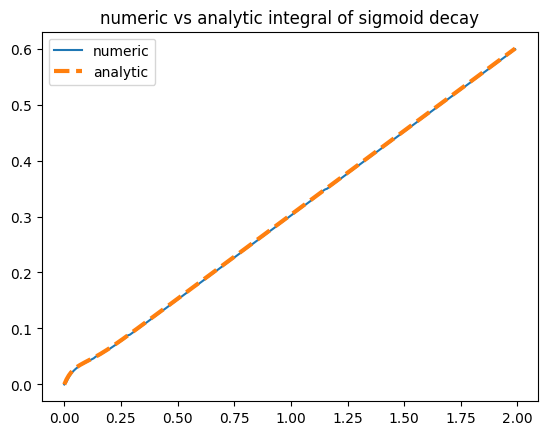

In [8]:
# integral checks?>
from tied_utils_decay2 import decay_sigmoid, decay_sigmoid_integral

t_pts = np.arange(0, 2, 0.01)
integ_numeric = np.zeros_like(t_pts)
decay_integ_vals = [decay_sigmoid_integral(t, gamma, mu_d, sigma_d, alpha) for t in t_pts]

for idx, t in enumerate(t_pts):
    integ_numeric[idx] = trapezoid([ decay_sigmoid(t, gamma, mu_d, sigma_d, alpha)  for t in np.arange(0, t, 0.005) ], \
                                   np.arange(0, t, 0.005))


plt.plot(t_pts, integ_numeric, label='numeric')
plt.plot(t_pts, decay_integ_vals, ls='--', lw=3, label='analytic')
plt.title('numeric vs analytic integral of sigmoid decay')
plt.legend();

In [9]:
ABL = ABL_arr[0]
ILD = ILD_arr[0]
data_bins=np.arange(0, 2, 0.01)
data_t_pts = data_bins[:-1] + (data_bins[1] - data_bins[0])/2

theory_bins = np.arange(0, 3, 5e-4)
t_pts = theory_bins[:-1] + (theory_bins[1] - theory_bins[0])/2


likelihood_up = np.zeros(len(t_pts))
likelihood_down = np.zeros(len(t_pts))
omega = (2 / (T_0 * (theta_E**2))) * (10**( (rate_lambda * ABL) / 20))

for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)


Area of up hist: 0.7142997476552032
Area of up theory: 0.7152717310597793
Area of down hist: 0.28265
Area of down theory: 0.2847279410841697


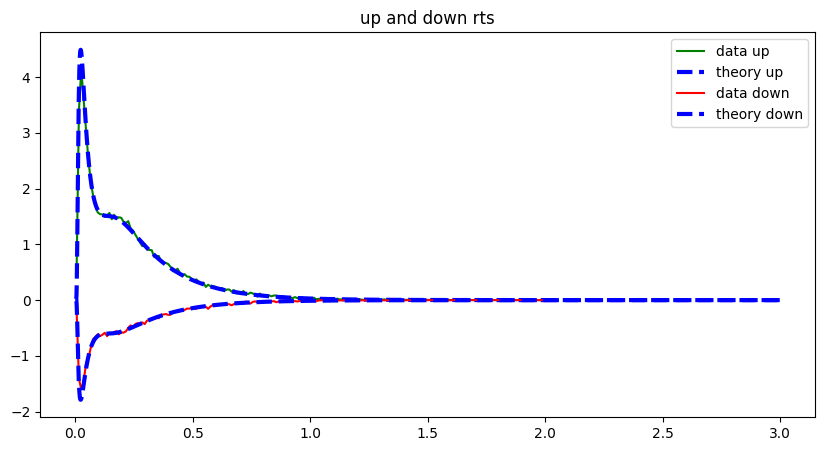

In [10]:
up_rts = [res['rt'] for res in sim_results if res['choice'] == 1 and res['ABL'] == ABL and res['ILD'] == ILD]
down_rts = [res['rt'] for res in sim_results if res['choice'] == -1 and res['ABL'] == ABL and res['ILD'] == ILD]

up_rt_hist, _ = np.histogram(up_rts, bins=data_bins, density=True)
down_rt_hist, _ = np.histogram(down_rts, bins=data_bins, density=True)

N_total = len([res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD])
N_up = len(up_rts)
N_down = len(down_rts)

plt.figure(figsize=(10, 5))
plt.plot(data_t_pts, up_rt_hist*(N_up/N_total), label='data up', color='g')
plt.plot(t_pts, likelihood_up, label='theory up', ls='--', color='b', lw=3)

plt.plot(data_t_pts, -down_rt_hist*(N_down/N_total), label='data down',  color='r')
plt.plot(t_pts, -likelihood_down, label='theory down', ls='--', color='b', lw=3)

plt.legend()
plt.title('up and down rts')
print(f'Area of up hist: {trapezoid(up_rt_hist, data_t_pts) * N_up/N_total}')
print(f'Area of up theory: {trapezoid(likelihood_up, t_pts)}')

print(f'Area of down hist: {trapezoid(down_rt_hist, data_t_pts) * N_down/N_total}')
print(f'Area of down theory: {trapezoid(likelihood_down, t_pts)}')

In [11]:
theory_all = np.zeros_like(t_pts)
for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    theory_all[idx] = likelihood_up + likelihood_down

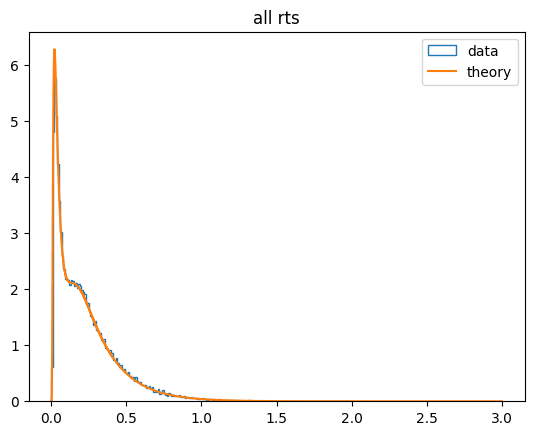

In [12]:
all_rts = [res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD]
plt.hist(all_rts, bins=data_bins, histtype='step', density=True, label='data');

plt.step(t_pts, theory_all, label='theory')
plt.legend()
plt.title('all rts');

In [13]:
import pickle
with open('only_tied_decay.pkl', 'wb') as f:
    pickle.dump(sim_results, f)

# loglike fn

In [12]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision, gamma, mu_d, sigma_d, alpha):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    omega = (2 / (T_0 * (theta_E**2))) * (10**( (rate_lambda * ABL) / 20))
    dtau_by_dt = omega * decay_sigmoid(rt - t_non_decision, gamma, mu_d, sigma_d, alpha)    

    decay_params = { 'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha }
    
    if choice == 1:
        prob = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision,\
                                                   omega, decay_params, dtau_by_dt)
    elif choice == -1:
        prob = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision,\
                                                   omega, decay_params, dtau_by_dt)

    if prob <= 0:
        return np.log(1e-50)
    else:
        return np.log(prob)

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision, gamma, mu_d, sigma_d, alpha = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision, \
                                                               gamma, mu_d, sigma_d, alpha) for res in sim_results)
    loglike = np.sum(all_loglike)

    return loglike

# Bounds

In [13]:
t_non_decision_bounds = [0*(1e-3), 50*(1e-3)]
rate_lambda_bounds = [0.1, 0.3]
T_0_bounds = [0.1*(1e-3), 1.5*(1e-3)]
theta_E_bounds = [10, 50]
gamma_bounds = [0.01, 0.1]
mu_d_bounds = [0.05, 0.2]
sigma_d_bounds = [0.01, 0.1]
alpha_bounds = [0.1, 0.5]

t_non_decision_plausible_bounds = [10*(1e-3), 30*(1e-3)]
rate_lambda_plausible_bounds = [0.15, 0.25]
T_0_plausible_bounds = [0.7*(1e-3), 1.2*(1e-3)]
theta_E_plausible_bounds = [15, 35]
gamma_plausible_bounds = [0.02, 0.05]
mu_d_plausible_bounds = [0.07, 0.15]
sigma_d_plausible_bounds = [0.03, 0.07]
alpha_plausible_bounds = [0.2, 0.4]


# True params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# Prior

In [14]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision, gamma, mu_d, sigma_d, alpha = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], \
                                            gamma_plausible_bounds[1], gamma_bounds[1])
    mu_d_logpdf = trapezoidal_logpdf(mu_d, mu_d_bounds[0], mu_d_plausible_bounds[0], \
                                            mu_d_plausible_bounds[1], mu_d_bounds[1])
    sigma_d_logpdf = trapezoidal_logpdf(sigma_d, sigma_d_bounds[0], sigma_d_plausible_bounds[0], \
                                            sigma_d_plausible_bounds[1], sigma_d_bounds[1])
    alpha_logpdf = trapezoidal_logpdf(alpha, alpha_bounds[0], alpha_plausible_bounds[0], alpha_plausible_bounds[1], alpha_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf + \
            gamma_logpdf + mu_d_logpdf + sigma_d_logpdf + alpha_logpdf

# prior + likelihood

In [15]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

# run vbmc

In [ ]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0], gamma_bounds[0], mu_d_bounds[0], sigma_d_bounds[0], alpha_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1], gamma_bounds[1], mu_d_bounds[1], sigma_d_bounds[1], alpha_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], \
                  t_non_decision_plausible_bounds[0], gamma_plausible_bounds[0], mu_d_plausible_bounds[0], sigma_d_plausible_bounds[0], alpha_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], \
                t_non_decision_plausible_bounds[1], gamma_plausible_bounds[1], mu_d_plausible_bounds[1], sigma_d_plausible_bounds[1], alpha_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])
gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
mu_d_0 = np.random.uniform(mu_d_plausible_bounds[0], mu_d_plausible_bounds[1])
sigma_d_0 = np.random.uniform(sigma_d_plausible_bounds[0], sigma_d_plausible_bounds[1])
alpha_0 = np.random.uniform(alpha_plausible_bounds[0], alpha_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0, gamma_0, mu_d_0, sigma_d_0, alpha_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

# corner

In [ ]:
vp_samples = vp.sample(int(1e5))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]*1e3
t_non_decision_samp = vp_samples[:, 3]
gamma_samp = vp_samples[:, 4]
mu_d_samp = vp_samples[:, 5]
sigma_d_samp = vp_samples[:, 6]
alpha_samp = vp_samples[:, 7]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp, gamma_samp, mu_d_samp, sigma_d_samp, alpha_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT', 'gamma', 'mu_d', 'sigma_d', 'alpha']
true_arr = [rate_lambda, theta_E, T_0*1e3, t_non_decision, gamma, mu_d, sigma_d, alpha]
# corner_span = [(0.07, 0.085), (46, 55), (0.16*(1e-3), 0.25*(1e-3)), (77*(1e-3), 79*(1e-3))]

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr, title_fmt=".4f"  );
 

In [ ]:
ILD_arr, ABL_arr

# Diagnostics

In [18]:
# rate_lambda_samp = vp_samples[:, 0]
# theta_E_samp = vp_samples[:, 1]
# T_0_samp = vp_samples[:, 2]*1e3
# t_non_decision_samp = vp_samples[:, 3]
# gamma_samp = vp_samples[:, 4]
# mu_d_samp = vp_samples[:, 5]
# sigma_d_samp = vp_samples[:, 6]
# alpha_samp = vp_samples[:, 7]

rate_lambda_mean = np.mean(rate_lambda_samp)
theta_E_mean = np.mean(theta_E_samp)
T_0_mean = np.mean(T_0_samp)
t_non_decision_mean = np.mean(t_non_decision_samp)
gamma_mean = np.mean(gamma_samp)
mu_d_mean = np.mean(mu_d_samp)
sigma_d_mean = np.mean(sigma_d_samp)
alpha_mean = np.mean(alpha_samp)


In [ ]:
T_0_mean = T_0_mean * 1e-3
T_0_mean

In [26]:
fit_sim_results = Parallel(n_jobs=-1)(delayed(tied_abs_units_decay)(ILD_arr, ABL_arr, rate_lambda_mean, theta_E_mean, T_0_mean, t_non_decision_mean, dt, \
                                                                    {'gamma': gamma_mean, 'mu_d': mu_d_mean, 'sigma_d': sigma_d_mean, 'alpha': alpha_mean}) for _ in range(N_sim))


In [27]:
from diagnostics_class import Diagnostics

In [ ]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df.head()

In [ ]:
fit_results_df = pd.DataFrame(fit_sim_results)
fit_results_df.head()

In [34]:
# add correct column = 1if ILD* choice > 1,  else 0
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice'] > 0).astype(int)

In [30]:
fit_results_df['correct'] = (fit_results_df['ILD'] * fit_results_df['choice'] > 0).astype(int)

In [31]:
sim_results_df['t_stim'] = 0
fit_results_df['t_stim'] = 0

In [32]:
sim_results_diag = Diagnostics(sim_results_df)
fit_results_diag = Diagnostics(fit_results_df)

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 19*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r' ,2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(0, 1, 0.01)
x, y = sim_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, ls='--', color='b')

x,y = fit_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, color='r', ls='--')


ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)


# 1 - psycho 
sim_psycho = sim_results_diag.plot_psycho()
all_ABL = sim_psycho.keys()
all_ILD = np.sort(ILD_arr)
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, sim_psycho[ABL], color=ABL_colors[ABL])

fit_psycho = fit_results_diag.plot_psycho()
for ABL in all_ABL:
    ax_psy.plot(all_ILD, fit_psycho[ABL], alpha=0.9, color=ABL_colors[ABL], ls='--')

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
# ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
all_ABL = np.sort(sim_results_df['ABL'].unique())
all_ILD = np.sort(sim_results_df['ILD'].unique())
all_ILD = all_ILD[all_ILD > 0] 

sim_chrono = {}

for ABL in all_ABL:
    per_ILD_rt = np.zeros_like(all_ILD ,dtype=float)
    for idx, ILD in enumerate(all_ILD):
        filtered_df = sim_results_df[ (sim_results_df['ABL'] == ABL) \
                                    & (sim_results_df['ILD'].isin([ILD, -ILD])) ]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    sim_chrono[ABL] = per_ILD_rt


fit_chrono = {}
for ABL in all_ABL:
    per_ILD_rt = np.zeros_like(all_ILD ,dtype=float)
    for idx, ILD in enumerate(all_ILD):
        filtered_df = fit_results_df[ (fit_results_df['ABL'] == ABL) \
                                    & (fit_results_df['ILD'].isin([ILD, -ILD])) ]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    fit_chrono[ABL] = per_ILD_rt

for ABL in sim_chrono.keys():
    ax_chrono.scatter(np.log(all_ILD), sim_chrono[ABL], color=ABL_colors[ABL])
    ax_chrono.plot(np.log(all_ILD), fit_chrono[ABL], color=ABL_colors[ABL], ls='--')

# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 0.4)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 0.6, 0.1))

# RTDs per ABL
al_ILD = np.sort(ILD_arr)
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']


        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim')

        fit_pd = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin([ILD, -ILD]))]
        fit_rt = fit_pd['rt'] - fit_pd['t_stim']

        fit_rt_hist, _ = np.histogram(fit_rt, density=True, bins=bins)
        ax.step(t_pts,fit_rt_hist, color=ILD_colors[ILD], label='fit', ls='--')



        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, -1, 2, -2, 4, -4]); easy_ILD = np.array([8, -8, 16, -16])
bins = np.arange(0, 0.6, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # fit - easy
    fit_pd_easy = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin(easy_ILD))]
    fit_pd_easy_diag = Diagnostics(fit_pd_easy)
    x, fit_easy_tacho = fit_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, fit_easy_tacho, label='fit easy', color='g', linestyle='--')

    # fit - hard
    fit_pd_hard = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin(hard_ILD))]
    fit_pd_hard_diag = Diagnostics(fit_pd_hard)
    x, fit_hard_tacho = fit_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, fit_hard_tacho, label='fit hard', color='r', linestyle='--')
    

    
    ax_r.set_xlabel(f'RT(s),ABL = {ABL}', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    # ax_r.set_xlim(0, 0.6)
    # ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)
